<a href="https://colab.research.google.com/github/lorenzozanisi/recommenderSystems/blob/master/Predict_affinity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import tensorflow as tf
import tensorflow.keras.layers as Layers
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.models import Model
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer, MinMaxScaler, LabelEncoder, OneHotEncoder
callbacks = [
        EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]

In [39]:
# adapted from https://keras.io/examples/structured_data/structured_data_classification_from_scratch/
def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x,y: tf.expand_dims(x[name],-1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature


Upload files from local


In [40]:
train = files.upload()

Saving train2.csv to train2 (1).csv


In [41]:
test = files.upload()

Saving test2.csv to test2.csv


In [42]:
tokens = files.upload()

Saving tokens2.csv to tokens2.csv


In [43]:
tokens = pd.read_csv('tokens2.csv')

In [44]:
tokens = tokens.drop(columns='creator')

In [45]:
train = pd.read_csv('train2.csv')
train = train.drop(columns='buyer')

In [50]:
test = pd.read_csv('test2.csv')

In [51]:
train = train.merge(tokens, on='tokenId')

In [52]:
test = test.merge(tokens, on='tokenId')

In [57]:
for c in test.columns:
  print(c+': '+str(len(test[~test[c].isna()])/len(test)))

buyerId: 1.0
tokenId: 1.0
buyer: 1.0
name: 1.0
description: 0.9931140015302219
tags: 1.0
image: 1.0
media: 0.5516449885233359
type: 0.5516449885233359
size: 0.5516449885233359
dimensions: 0.5378729915837797
creatorId: 1.0


Prepare data for 3-entry NeuMF model


In [431]:
merged = merged[['buyerId','tokenId','creatorId','affinity']]
merged_labels = merged['affinity'].values
MergedDataSet = tf.data.Dataset.from_tensor_slices((dict(merged), merged_labels)).shuffle(buffer_size=len(merged)).batch(32)

In [406]:
train, test = train_test_split(merged, test_size= 0.2)
test_labels = test.pop('affinity')

train_val_split = 0.2
Nval = int(len(train)*train_val_split)
val = train.loc[:Nval,:]
val_labels = val.pop('affinity')

train = train.loc[Nval:,:]
train_labels = train.pop('affinity')


trainset = tf.data.Dataset.from_tensor_slices((dict(train), train_labels)).shuffle(buffer_size=len(train)).batch(32)
validset = tf.data.Dataset.from_tensor_slices((dict(val), val_labels)).batch(32)
testset =  tf.data.Dataset.from_tensor_slices((dict(test), test_labels)).batch(32)

In [407]:
#preprocess withone hot encoding
user = Layers.Input(shape=(1,),name='buyerId')
item = Layers.Input(shape=(1,),name='tokenId')
artist = Layers.Input(shape=(1,),name='creatorId')

user_encoded = encode_integer_categorical_feature(user, "buyerId", MergedDataSet)
item_encoded = encode_integer_categorical_feature(item, "tokenId", MergedDataSet)
artist_encoded = encode_integer_categorical_feature(artist, "creatorId", MergedDataSet)

In [369]:
def NeuMF_with_artists(inputs,inputs_encoded, MF_ui_embedding_size = 32,
                       MF_ua_embedding_size =48, MLP_embedding_size = 32,
                       dropout=0.0):

  
  user_encoded, item_encoded, artist_encoded = inputs_encoded
  user, item, artist = inputs

  #GMF branches

  #1. user-item

  embed_MF_ui_user = Layers.Dense(MF_ui_embedding_size)(user_encoded)
  embed_MF_ui_item = Layers.Dense(MF_ui_embedding_size)(item_encoded)
  GMF_ui = Layers.Multiply()([embed_MF_ui_user, embed_MF_ui_item])

  #2. user-artist

  embed_MF_ua_user = Layers.Dense(MF_ua_embedding_size)(user_encoded)
  embed_MF_ua_artist = Layers.Dense(MF_ua_embedding_size)(artist_encoded)
  GMF_ua = Layers.Multiply()([embed_MF_ua_user, embed_MF_ua_artist])


  #Dense branches

  #1. user-item 

  Dense_user_ui = Layers.Dense(MLP_embedding_size)(user_encoded)
  Dense_item_ui = Layers.Dense(MLP_embedding_size)(item_encoded)
  concatenate_1_ui = Layers.concatenate([Dense_user_ui, Dense_item_ui])

  d1_ui = Layers.Dense(64, activation='relu')(concatenate_1_ui)
  dropout1_ui = Layers.Dropout(dropout)(d1_ui)
  d2_ui = Layers.Dense(32, activation='relu')(dropout1_ui)
  dropout2_ui = Layers.Dropout(dropout)(d2_ui)
  d3_ui = Layers.Dense(16, activation='relu')(dropout2_ui)
  dropout3_ui = Layers.Dropout(dropout)(d3_ui)
  d4_ui = Layers.Dense(8, activation='relu')(dropout3_ui)

  #2. user-artist

  Dense_user_ua = Layers.Dense(MLP_embedding_size)(user_encoded)
  Dense_artist_ua = Layers.Dense(MLP_embedding_size)(artist_encoded)
  concatenate_1_ua = Layers.concatenate([Dense_user_ua, Dense_artist_ua])

  d1_ua = Layers.Dense(64, activation='relu')(concatenate_1_ua)
  dropout1_ua = Layers.Dropout(dropout)(d1_ua)
  d2_ua = Layers.Dense(32, activation='relu')(dropout1_ua)
  dropout2_ua = Layers.Dropout(dropout)(d2_ua)
  d3_ua = Layers.Dense(16, activation='relu')(dropout2_ua)
  dropout3_ua = Layers.Dropout(dropout)(d3_ua)
  d4_ua = Layers.Dense(8, activation='relu')(dropout3_ua)


  # Final layers

  NeuMF = Layers.concatenate([d4_ui,d4_ua,GMF_ui,GMF_ua])

  
  #NeuMF = Layers.concatenate([GMF_ui,GMF_ua])
  prediction = Layers.Dense(1)(NeuMF)

  NeuMF = Model([user,item,artist], prediction)

  return NeuMF

In [408]:
model_uia = NeuMF_with_artists([user,item,artist],[user_encoded,item_encoded,artist_encoded], dropout=0.1)
model_uia.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
          loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])# mean_squared_error', )   #we will need to weigh our loss
history_uia = model_uia.fit(trainset, epochs=10, validation_data=validset, callbacks=callbacks)

Epoch 1/10
128/128 [==============================] - 4s 23ms/step - loss: 6.8557 - root_mean_squared_error: 2.6138 - val_loss: 5.2675 - val_root_mean_squared_error: 2.2951
Epoch 2/10
128/128 [==============================] - 3s 21ms/step - loss: 4.5375 - root_mean_squared_error: 2.1287 - val_loss: 4.4911 - val_root_mean_squared_error: 2.1192
Epoch 3/10
128/128 [==============================] - 3s 21ms/step - loss: 1.9787 - root_mean_squared_error: 1.4057 - val_loss: 4.5755 - val_root_mean_squared_error: 2.1390
Epoch 4/10
128/128 [==============================] - 3s 21ms/step - loss: 0.8271 - root_mean_squared_error: 0.9091 - val_loss: 4.5830 - val_root_mean_squared_error: 2.1408
Epoch 00004: early stopping


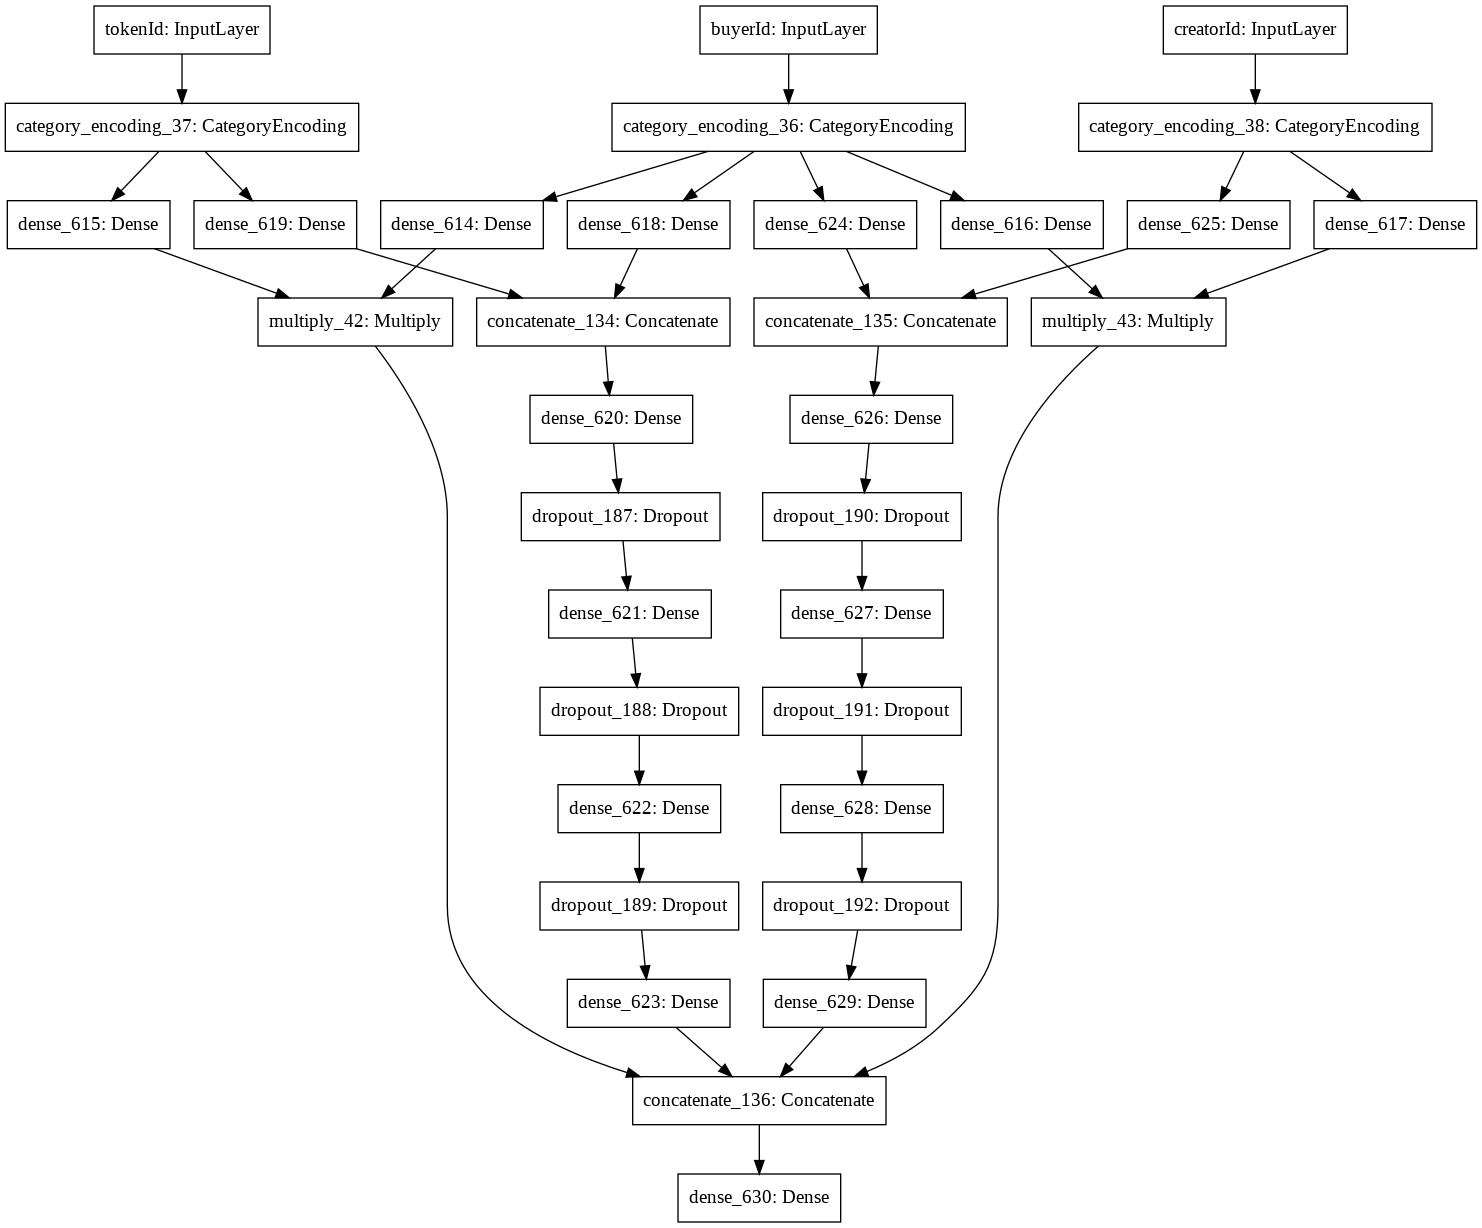

In [362]:
tf.keras.utils.plot_model(model_uia, show_shapes=False)

Attempt to solve the problem using classification instead

Categorical binning

In [484]:
Train = pd.read_csv('train2.csv')
Train = Train.drop(columns='buyer')
Train_labels = Train['affinity'].values
TrainDataSet = tf.data.Dataset.from_tensor_slices((dict(Train), Train_labels)).shuffle(buffer_size=len(Train)).batch(32)

bins = np.linspace(0,10,11)
#Train['affinity_categorical'] = pd.cut(Train['affinity'], bins=bins, labels=bins[::-1][1:][::-1])

#Train = Train.drop(columns='affinity')
#Train.loc[:,'affinity_categorical'] =  Train.loc[:,'affinity_categorical'].map(lambda x: int(x))

train, test = train_test_split(Train, test_size= 0.2, random_state=1000)
test_labels = test.pop('affinity')#_categorical')

train_val_split = 0.2
Nval = int(len(train)*train_val_split)
val = train.loc[:Nval,:]
val_labels = val.pop('affinity')#_categorical')

train = train.loc[Nval:,:]
train_labels = train.pop('affinity')#_categorical')


trainset = tf.data.Dataset.from_tensor_slices((dict(train), train_labels)).shuffle(buffer_size=len(train)).batch(32)
validset = tf.data.Dataset.from_tensor_slices((dict(val), val_labels)).batch(32)
testset =  tf.data.Dataset.from_tensor_slices((dict(test), test_labels)).batch(32)




In [493]:
#preprocess withone hot encoding
user = Layers.Input(shape=(1,),name='buyerId')
item = Layers.Input(shape=(1,),name='tokenId')
user_encoded = encode_integer_categorical_feature(user, "buyerId", TrainDataSet)
item_encoded = encode_integer_categorical_feature(item, "tokenId", TrainDataSet)

In [472]:
class_weights = merged.groupby('affinity_categorical').sum().reset_index()[['affinity_categorical','buyerId']]
class_weights = class_weights.rename(columns={'buyerId':'weight'})
class_weights.loc[:,'weight'] = class_weights.loc[:,'weight'].apply(lambda x: 1/x)

array([1.35577778e-07, 9.68158244e-07, 2.28089703e-06, 3.53036289e-06,
       4.87633612e-06, 8.99749870e-06, 1.13593766e-05, 1.60156313e-05,
       1.74137150e-05, 2.41174229e-06])

In [699]:
def MLP_classification(inputs,inputs_encoded,MLP_embedding_size=32):

  user_encoded, item_encoded = inputs_encoded
  user, item = inputs

  #embedding
  Dense_user = Layers.Dense(MLP_embedding_size)(user_encoded)
  Dense_item = Layers.Dense(MLP_embedding_size)(item_encoded)
  concatenate_1 = Layers.concatenate([Dense_user, Dense_item])


  d1 = Layers.Dense(64, activation='relu')(concatenate_1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dropout(dropout)(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dropout(dropout)(d1)
  d1 = Layers.Dense(16, activation='relu')(d1)
  d1 = Layers.Dense(16, activation='relu')(d1)
  d1 = Layers.Dense(16, activation='relu')(d1)
  d1 = Layers.Dense(16, activation='relu')(d1)
  d1 = Layers.Dropout(dropout)(d1)
  #d4 = Layers.Dense(8, activation='relu')(dropout3)


 # NeuMF = Layers.concatenate([d4,GMF])

  prediction = Layers.Dense(10)(d4)
  MLP = Model([user,item], prediction)

  return MLP

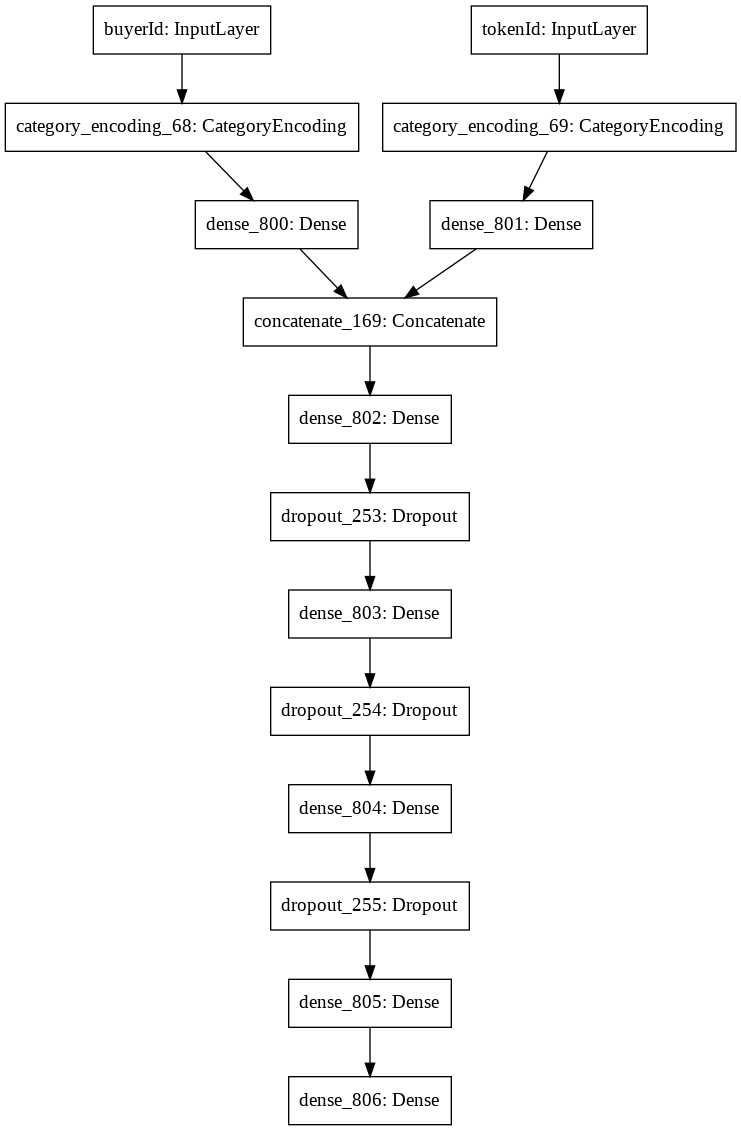

In [499]:
tf.keras.utils.plot_model(MLP)

In [503]:
MLP = MLP_classification([user,item],[user_encoded,item_encoded])
MLP.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
          loss='mean_squared_error',#tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
           metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [505]:
MLP.fit(epochs=10)#, validation_data=validset, callbacks=callbacks)   # for some reason this failed in the latest run, 
                                                                      # anyway the performance of this model is very bad (see below)

ValueError: ignored

2-branch NeuMF model

In [725]:
Train = pd.read_csv('train2.csv')
Train = Train.drop(columns='buyer')
N = 10
labels = np.linspace(0,N,N+1)
Train.loc[:,'affinity_cat'] = pd.cut(Train.loc[:,'affinity'], bins=N, labels=labels[::-1][1:][::-1])
Train.loc[:,'affinity_cat'] = Train.loc[:,'affinity_cat'].cat.codes
Train = Train.drop(columns='affinity')

Train_labels = Train['affinity_cat'].values
TrainDataSet = tf.data.Dataset.from_tensor_slices((dict(Train), Train_labels)).shuffle(buffer_size=len(Train)).batch(32)
train, test = train_test_split(Train, test_size= 0.2,random_state=1000)

test_labels = test.pop('affinity_cat')
test_labels = test_labels.astype(int)


train_val_split = 0.2
Nval = int(len(train)*train_val_split)
val = train.loc[:Nval,:]
val_labels = val.pop('affinity_cat')
val_labels = val_labels.astype(int)

train = train.loc[Nval:,:]

class_weights = train.groupby('affinity_cat').sum().reset_index()[['affinity_cat','buyerId']]
class_weights = class_weights.rename(columns={'buyerId':'weight'})
class_weights.loc[:,'weight'] = class_weights.loc[:,'weight'].apply(lambda x: 1/x)

class_weights = class_weights.to_dict()

train_labels = train.pop('affinity_cat')
train_labels = train_labels.astype(int)


trainset = tf.data.Dataset.from_tensor_slices((dict(train), train_labels)).shuffle(buffer_size=len(train)).batch(32)
validset = tf.data.Dataset.from_tensor_slices((dict(val), val_labels)).batch(32)
testset =  tf.data.Dataset.from_tensor_slices((dict(test), test_labels)).batch(32)

In [728]:
class_weights = class_weights['weight']
class_weights

{0: 2.0838477832548243e-07,
 1: 1.5120152290173866e-06,
 2: 3.6233459425772137e-06,
 3: 5.689447213308755e-06,
 4: 7.483573556044482e-06,
 5: 1.3796719140188464e-05,
 6: 1.85563184264242e-05,
 7: 2.8315777551251557e-05,
 8: 2.9792051480664958e-05,
 9: 3.717665603414304e-06}

In [729]:
sum = np.array(list(class_weights.values())).sum()
for c in class_weights.keys():
  class_weights[c]/=sum
class_weights

{0: 0.0018490991223259487,
 1: 0.013416843856764676,
 2: 0.032151704438977774,
 3: 0.05048522225657471,
 4: 0.06640537473773515,
 5: 0.1224249748858956,
 6: 0.16465920587687138,
 7: 0.25125961617127074,
 8: 0.2643593101562473,
 9: 0.03298864849733665}

In [730]:
#preprocess withone hot encoding
user = Layers.Input(shape=(1,),name='buyerId')
item = Layers.Input(shape=(1,),name='tokenId')
user_encoded = encode_integer_categorical_feature(user, "buyerId", TrainDataSet)
item_encoded = encode_integer_categorical_feature(item, "tokenId", TrainDataSet)



In [713]:
def MLP_classification(inputs,inputs_encoded,MLP_embedding_size=32):

  user_encoded, item_encoded = inputs_encoded
  user, item = inputs

  #embedding
  Dense_user = Layers.Dense(MLP_embedding_size, activation='relu')(user_encoded)
  Dense_item = Layers.Dense(MLP_embedding_size, activation='relu')(item_encoded)
  concatenate_1 = Layers.concatenate([Dense_user, Dense_item])

 # if N>16:
 #   raise ValueError

  d1 = Layers.Dense(128, activation='relu')(concatenate_1)
  d1 = Layers.Dense(128, activation='relu')(d1)
  d1 = Layers.Dense(128, activation='relu')(d1)
  d1 = Layers.Dense(128, activation='relu')(d1)
  d1 = Layers.Dropout(dropout)(d1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dense(64, activation='relu')(d1)
  d1 = Layers.Dropout(dropout)(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  d1 = Layers.Dense(32, activation='relu')(d1)
  #d1 = Layers.Dropout(dropout)(d1)
  #d4 = Layers.Dense(8, activation='relu')(dropout3)


 # NeuMF = Layers.concatenate([d4,GMF])

  prediction = Layers.Dense(N)(d1)
  MLP = Model([user,item], prediction)

  return MLP

In [714]:
mlp = MLP_classification([user,item],[user_encoded,item_encoded])
mlp.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.RootMeanSquaredError(), 'accuracy'])# mean_squared_error', )   #we will need to weigh our loss
history_mlp = model_dropout02.fit(trainset, epochs=10, class_weight=class_weights,  validation_data=validset)#, callbacks=callbacks)

Epoch 1/10
246/246 [==============================] - 4s 15ms/step - loss: 2.0874e-04 - root_mean_squared_error: 21.5720 - accuracy: 0.9927 - val_loss: 3.2938 - val_root_mean_squared_error: 13.1689 - val_accuracy: 0.4125
Epoch 2/10
246/246 [==============================] - 4s 15ms/step - loss: 2.5215e-04 - root_mean_squared_error: 20.5025 - accuracy: 0.9938 - val_loss: 3.7751 - val_root_mean_squared_error: 12.2631 - val_accuracy: 0.3849
Epoch 3/10
246/246 [==============================] - 3s 14ms/step - loss: 1.0541e-04 - root_mean_squared_error: 21.9928 - accuracy: 0.9961 - val_loss: 3.1301 - val_root_mean_squared_error: 12.4499 - val_accuracy: 0.4178
Epoch 4/10
246/246 [==============================] - 4s 14ms/step - loss: 6.7681e-05 - root_mean_squared_error: 22.9514 - accuracy: 0.9973 - val_loss: 3.2583 - val_root_mean_squared_error: 13.8968 - val_accuracy: 0.4581
Epoch 5/10
246/246 [==============================] - 4s 15ms/step - loss: 1.3702e-04 - root_mean_squared_error: 22.

In [15]:
def NeuMF(inputs,inputs_encoded, MF_embedding_size = 32,
          MLP_embedding_size = 32,dropout=0.2, choice=None):

  
  user_encoded, item_encoded = inputs_encoded
  user, item = inputs

  #GMF branch

  embed_MF_user = Layers.Dense(MF_embedding_size)(user_encoded)
  embed_MF_item = Layers.Dense(MF_embedding_size)(item_encoded)
  GMF = Layers.Multiply()([embed_MF_user, embed_MF_item])

  Dense_user = Layers.Dense(MLP_embedding_size)(user_encoded)
  Dense_item = Layers.Dense(MLP_embedding_size)(item_encoded)
  concatenate_1 = Layers.concatenate([Dense_user, Dense_item])

  d1 = Layers.Dense(128, activation='relu')(concatenate_1)
  dropout1 = Layers.Dropout(dropout)(d1)
  d2 = Layers.Dense(64, activation='relu')(dropout1)
  dropout2 = Layers.Dropout(dropout)(d2)
  d3 = Layers.Dense(32, activation='relu')(dropout2)
  dropout3 = Layers.Dropout(dropout)(d3)
  d4 = Layers.Dense(32, activation='relu')(dropout3)


  NeuMF = Layers.concatenate([d4,GMF])

  if choice =='clf':
    prediction = Layers.Dense(len(class_weights))(NeuMF)
  else:
    prediction = Layers.Dense(1)(NeuMF)
  NeuMF = Model([user,item], prediction)

  return NeuMF

In [169]:
history = m.fit(trainset, epochs=10, validation_data=validset, callbacks=callbacks)

Epoch 1/10
138/138 [==============================] - 2s 17ms/step - loss: 0.5727 - val_loss: 0.5949
Epoch 2/10
138/138 [==============================] - 3s 18ms/step - loss: 0.3187 - val_loss: 0.6524
Epoch 3/10
138/138 [==============================] - 2s 17ms/step - loss: 0.2119 - val_loss: 0.6503
Epoch 00003: early stopping


In [732]:
model_dropout02 = NeuMF([user,item],[user_encoded,item_encoded], dropout=0.2)
model_dropout02.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.RootMeanSquaredError(), 'accuracy'])# mean_squared_error', )   #we will need to weigh our loss
history_dropout2 = model_dropout02.fit(trainset, epochs=10, class_weight=class_weights,  validation_data=validset)#, callbacks=callbacks)

Epoch 1/10
246/246 [==============================] - 5s 15ms/step - loss: 0.0354 - root_mean_squared_error: 2.4577 - accuracy: 0.0325 - val_loss: 2.3283 - val_root_mean_squared_error: 2.5663 - val_accuracy: 0.0106
Epoch 2/10
246/246 [==============================] - 3s 14ms/step - loss: 0.0354 - root_mean_squared_error: 2.5751 - accuracy: 0.0493 - val_loss: 1.9655 - val_root_mean_squared_error: 2.6692 - val_accuracy: 0.3897
Epoch 3/10
246/246 [==============================] - 4s 14ms/step - loss: 0.0289 - root_mean_squared_error: 2.7136 - accuracy: 0.4454 - val_loss: 1.8677 - val_root_mean_squared_error: 3.1274 - val_accuracy: 0.3309
Epoch 4/10
246/246 [==============================] - 4s 14ms/step - loss: 0.0171 - root_mean_squared_error: 4.1602 - accuracy: 0.5751 - val_loss: 2.0316 - val_root_mean_squared_error: 3.8177 - val_accuracy: 0.4348
Epoch 5/10
246/246 [==============================] - 4s 15ms/step - loss: 0.0098 - root_mean_squared_error: 4.8773 - accuracy: 0.8114 - val

In [539]:
for i in trainset.take(1):
  print(i)

({'buyerId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1068,  313,  246, 1250,  536,   61,  199,  411,  249,  572,  739,
       1353, 1233,  231, 1433,   61,  907,   96, 1420,  650,   96,  991,
        313,  522,  344,  404,  275, 1012, 1140,  639,   96,  739])>, 'tokenId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([11164,  4274, 17563, 16523, 10759, 17085,  6378,  7058,  8766,
       11127,  2320,  2725,  3159,   596,  8891, 11628,   446, 12146,
        6532, 10091, 12538, 16171, 11610, 15800,   760,  6170,  3988,
        5825,  8686, 12030,  5520,  5016])>}, <tf.Tensor: shape=(32,), dtype=float64, numpy=
array([9., 0., 2., 0., 0., 0., 9., 0., 9., 0., 0., 0., 0., 2., 0., 0., 0.,
       0., 0., 6., 0., 2., 0., 0., 0., 0., 0., 0., 1., 1., 7., 2.])>)


Attempt to use sample weights, failed because tf.data.Dataset does not support sample weights during training


In [18]:
import numpy as np
import pandas as pd
Train = pd.read_csv('train2.csv')
Train = Train.drop(columns='buyer')

Train_labels = Train['affinity'].values
TrainDataSet = tf.data.Dataset.from_tensor_slices((dict(Train), Train_labels)).shuffle(buffer_size=len(Train)).batch(32)
train, test = train_test_split(Train, test_size= 0.2,random_state=1000)

test_labels = test.pop('affinity')
test_labels = test_labels.astype(int)


train_val_split = 0.2
Nval = int(len(train)*train_val_split)
val = train.loc[:Nval,:]
val_labels = val.pop('affinity')
val_labels = val_labels.astype(int)

train = train.loc[Nval:,:]
N = 10
labels = np.linspace(0,N,N+1)
train.loc[:,'affinity_cat'] = pd.cut(train.loc[:,'affinity'], bins=N, labels=labels[::-1][1:][::-1])
train.loc[:,'affinity_cat'] = train.loc[:,'affinity_cat'].cat.codes


sample_weights = train.groupby('affinity_cat').count().reset_index()[['affinity_cat','buyerId']]
sample_weights = sample_weights.rename(columns={'buyerId':'weight'})
sample_weights.loc[:,'weight'] = sample_weights.loc[:,'weight'].apply(lambda x: 1/x)

sum = sample_weights['weight'].sum()
sample_weights['weight'] = sample_weights['weight']/sum
train = train.merge(sample_weights, on='affinity_cat')

sample_weights = train[['weight','affinity']]
train = train.drop(columns=['affinity_cat','weight'])
train_labels = train.pop('affinity')
train_labels = train_labels.astype(int)


trainset = tf.data.Dataset.from_tensor_slices((dict(train), train_labels)).batch(32)
validset = tf.data.Dataset.from_tensor_slices((dict(val), val_labels)).batch(32)
testset =  tf.data.Dataset.from_tensor_slices((dict(test), test_labels)).batch(32)

In [19]:
train

,buyerId,tokenId
0,1458,4381
1,1144,8250
2,1433,7067
3,739,14848
4,924,1879
...,...,...
7848,368,15401
7849,1260,17760
7850,378,346
7851,3,14636


In [20]:
#preprocess withone hot encoding
user = Layers.Input(shape=(1,),name='buyerId')
item = Layers.Input(shape=(1,),name='tokenId')
user_encoded = encode_integer_categorical_feature(user, "buyerId", TrainDataSet)
item_encoded = encode_integer_categorical_feature(item, "tokenId", TrainDataSet)

In [835]:
tf.keras.losses.MeanSquaredError??
class WeightedLoss(tf.keras.losses.MeanSquaredError):
  def __init__(self, name='weighted_loss'):
    super().__init__()(name)
  

In [36]:
import tensorflow.keras.backend as kb
def custom_loss(y_actual,y_pred):
  with tf.compat.v1.Session().as_default():
    print(type(y_actual.eval()))
  w = sample_weights[sample_weights['affinity']==y_actual]#.values[0]
  custom_loss=kb.square(y_actual-y_pred)
  return custom_loss

In [37]:

model_dropout02 = NeuMF([user,item],[user_encoded,item_encoded], dropout=0.2)
model_dropout02.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
          loss=custom_loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])# mean_squared_error', )   #we will need to weigh our loss
history_dropout2 = model_dropout02.fit(trainset, epochs=10,  validation_data=validset)#, callbacks=callbacks)



Epoch 1/10


InvalidArgumentError: ignored

In [745]:
tf.se

({'buyerId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([1458, 1144, 1433,  739,  924,  522,  607,  765,  107, 1170,  559,
        929,  935,  855,  186,  630,  739, 1184, 1473,   84, 1336,  765,
       1353, 1308,  924,   61,  887, 1353,  410, 1310,  833,  287])>, 'tokenId': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([ 4381,  8250,  7067, 14848,  1879,  1701, 16745,   199, 17815,
        4512,  9775,  6952, 16915, 10327,  5946,  5711,  8077,  8860,
        1558, 13234, 16899,  3412,  7858,  2422,  3175,  2948, 17527,
        6164,   273, 10782,  2691, 13556])>}, <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 3, 1, 2, 0, 3, 0, 0, 1, 0, 0, 6, 0, 0, 0, 8,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0])>)
